# Autómata Celular: Incendio en un Bosque

**Objetivo.** Implementar y explorar un autómata celular para modelar un incendio forestal con propagación aleatoria.
Trabajaremos con **tres estados por celda**:
- **0 = árbol sano (verde)**
- **1 = árbol en llamas (rojo)**
- **2 = árbol quemado (negro)**

La propagación es **aleatoria**: un árbol sano con **al menos un vecino en llamas** se enciende en el siguiente paso con probabilidad $p \in [0,1]$.
Usaremos por defecto la **vecindad de Moore (8 vecinos)** y bordes abiertos (no periódicos).

## Reglas del modelo
Sea $X_t \in \{0,1,2\}^{N\times N}$ la configuración en el tiempo $t$:
1. Si $X_t(i,j) = 1$ (en llamas), entonces $X_{t+1}(i,j) = 2$ (quemado).
2. Si $X_t(i,j) = 0$ (sano) **y** tiene al menos un vecino en estado 1, entonces
   $$\mathbb P\big(X_{t+1}(i,j) = 1\big) = p.$$
   En caso contrario, permanece sano.
3. Si $X_t(i,j) = 2$ (quemado), permanece quemado.

## Setup 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import pandas as pd

# Colores solicitados: 0=verde (sano), 1=rojo (en llamas), 2=negro (quemado)
cmap = ListedColormap(['#2ca02c', '#d62728', '#000000'])
norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)

def mostrar_mapa(x, ax=None, titulo=None, grid=False):
    """Muestra un mapa de estados con la paleta verde/rojo/negro."""
    if ax is None:
        fig, ax = plt.subplots()
    im = ax.imshow(x, cmap=cmap, norm=norm, interpolation='nearest', origin='upper')
    if titulo:
        ax.set_title(titulo)
    ax.set_xticks([]); ax.set_yticks([])
    if grid:
        ax.set_xticks(np.arange(-.5, x.shape[1], 1), minor=True)
        ax.set_yticks(np.arange(-.5, x.shape[0], 1), minor=True)
        ax.grid(which='minor', linewidth=0.2)
    return im

In [5]:
def bosque_inicial(N, densidad_fuego=0.01, semilla=None):
    """
    Crea un bosque N x N con todos los árboles sanos (0),
    y enciende aleatoriamente una fracción 'densidad_fuego' de celdas (estado 1).
    Parámetros
    ----------
    N : int
        Tamaño del bosque (N x N).
    densidad_fuego : float in [0,1]
        Fracción inicial de árboles encendidos (focos).
    semilla : int | None
        Semilla para la reproducibilidad.
    """
    rng = np.random.default_rng(semilla)
    x = np.zeros((N, N), dtype=np.uint8)  # 0 = sano
    mascara_fuego = rng.random((N, N)) < densidad_fuego
    x[mascara_fuego] = 1  # 1 = en llamas
    return x

In [ ]:

def _vecinos_en_llamas(x, neighborhood='Moore'):
    """Devuelve, para cada celda, la cantidad de vecinos en llamas (estado 1).
    Bordes abiertos (no periódicos).
    """
    N, M = x.shape
    burning = (x == 1).astype(np.uint8)
    nb = np.zeros_like(burning, dtype=np.uint8)

    if neighborhood == 'Moore':
        dirs_ = [(di, dj) for di in (-1,0,1) for dj in (-1,0,1) if not (di==0 and dj==0)]
    elif neighborhood == 'VonNeumann':
        dirs_ = [(-1,0),(1,0),(0,-1),(0,1)]
    else:
        raise ValueError("neighborhood debe ser 'Moore' u 'VonNeumann'")

    # Contar vecinos con chequeo de bordes
    for i in range(N):
        for j in range(M):
            if x[i, j] == 2:
                continue  # opcional, igual lo contamos de todos modos
            c = 0
            for di, dj in dirs_:
                ii, jj = i + di, j + dj
                if 0 <= ii < N and 0 <= jj < M:
                    c += (x[ii, jj] == 1)
            nb[i, j] = c
    return nb

def paso_incendio(x, p=0.5, neighborhood='Moore', rng=None):
    """
    Un paso de tiempo del autómata de incendio.
    - 1 -> 2 (en llamas -> quemado)
    - 0 con vecinos en llamas -> 1 con probabilidad p
    - 2 -> 2
    """
    if rng is None:
        rng = np.random.default_rng()
    x = np.asarray(x, dtype=np.uint8)
    y = x.copy()

    # Primero: los que están en llamas pasan a quemados
    y[x == 1] = 2

    # Segundo: sanos con vecinos en llamas pueden encenderse con probabilidad p
    nb = _vecinos_en_llamas(x, neighborhood=neighborhood)
    # Ahora (probabilidad 1 - (1-p)^nb):
    susceptibles = (x == 0) & (nb > 0)
    prob_ignite = 1.0 - (1.0 - p)**nb
    ignites = susceptibles & (rng.random(x.shape) < prob_ignite)
    y[ignites] = 1
    return y

### ¿Por qué usar varias veces la probabilidad $p$ es equivalente a $1 - (1 - p)^{n_b}$?

Supongamos que un árbol sano tiene $n_b$ vecinos en llamas, y que **cada vecino intenta prenderlo de forma independiente** con probabilidad $p$.

- La probabilidad de que **un solo vecino** *no* lo prenda es $(1 - p)$.
- Como los intentos son **independientes**, la probabilidad de que **ninguno de los $n_b$ vecinos** lo prenda es:
  $$
  (1 - p)^{n_b}.
  $$
- Por lo tanto, la probabilidad complementaria —es decir, de que **al menos uno lo prenda**— es:
  $$
  1 - (1 - p)^{n_b}.
  $$

Esto significa que en lugar de simular $n_b$ intentos separados con probabilidad $p$ cada uno, podemos **resumirlos en una sola comparación aleatoria** usando esta probabilidad acumulada.

En código, es equivalente a:

```python
susceptibles = (x == 0) & (nb > 0)
prob_ignite = 1.0 - (1.0 - p)**nb
ignites = susceptibles & (rng.random(x.shape) < prob_ignite)


In [7]:

def evolucion_incendio(estado_inicial, pasos, p=0.5, neighborhood='Moore', semilla=None, parada_temprana=True):
    """Evoluciona el sistema y devuelve un arreglo de forma (pasos+1, N, N)."""
    rng = np.random.default_rng(semilla)
    x = np.array(estado_inicial, dtype=np.uint8)
    N, M = x.shape
    Mout = np.zeros((pasos + 1, N, M), dtype=np.uint8)
    Mout[0] = x
    for t in range(pasos):
        x = paso_incendio(x, p=p, neighborhood=neighborhood, rng=rng)
        Mout[t + 1] = x
        if parada_temprana and (x == 1).sum() == 0:  # ya no hay fuego activo
            # Rellenamos estados restantes con el último (estacionario)
            for tt in range(t + 1, pasos):
                Mout[tt + 1] = x
            break
    return Mout

def animar_evolucion(M, interval=120, guardar_como=None):
    fig, ax = plt.subplots()
    im = ax.imshow(M[0], cmap=cmap, norm=norm, interpolation='nearest')
    ax.set_xticks([]); ax.set_yticks([])
    def update(frame):
        im.set_data(M[frame])
        ax.set_title(f"t = {frame}")
        return im,
    anim = FuncAnimation(fig, update, frames=M.shape[0], interval=interval, blit=True)
    if guardar_como:
        anim.save(guardar_como)
    plt.close(fig)
    return anim


## Implementación

Ejecuta el siguiente bloque para ver una simulación de ejemplo y su animación.


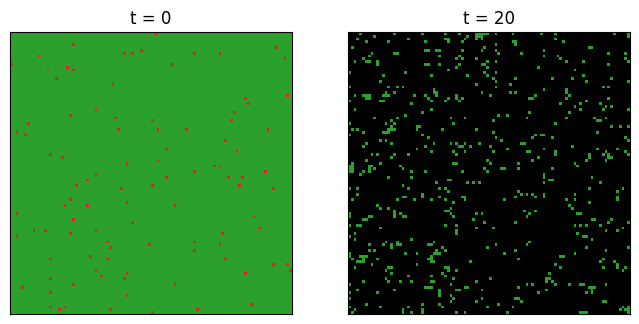

In [8]:

# Parámetros de ejemplo
N = 100
densidad_fuego = 0.01  # fracción inicial en llamas (rho_0)
p = 0.5                # probabilidad de propagación
pasos = 20
semilla = 42

X0 = bosque_inicial(N, densidad_fuego=densidad_fuego, semilla=semilla)
M = evolucion_incendio(X0, pasos, p=p, neighborhood='Moore', semilla=semilla)

# Mostrar estado inicial y final
fig, axs = plt.subplots(1, 2, figsize=(8,4))
mostrar_mapa(M[0], ax=axs[0], titulo="t = 0")
mostrar_mapa(M[-1], ax=axs[1], titulo=f"t = {M.shape[0]-1}")
plt.show()

# Animación (se mostrará en la celda)
anim = animar_evolucion(M, interval=100)
HTML(anim.to_jshtml())


## Ejercicios

La pregunta objetivo es la siguiente:

> **¿Qué combinaciones de la densidad inicial de árboles incendiados $\rho_0$ y la probabilidad de propagación $p$ provocan que *todo el bosque* se consuma?**

En estos ejercicios, **no es necesario realizar cálculos**, sino **observar visualmente las animaciones** del autómata.  
El propósito es que identifiques, a partir de la evolución del fuego, los escenarios donde el incendio logra expandirse por completo y aquellos donde se extingue rápidamente.


1. **Variación de la densidad inicial $\rho_0$ (focos de fuego):**  
   - Fija una probabilidad de propagación, por ejemplo $p = 0.5$.  
   - Ejecuta varias simulaciones variando $\rho_0$ (por ejemplo, 0.001, 0.01, 0.05).  
   - **Observa visualmente**:  
     - ¿Cuándo el fuego se propaga ampliamente?  
     - ¿Cuándo se apaga antes de alcanzar todo el bosque?

2. **Variación de la probabilidad de propagación $p$:**  
   - Fija una densidad inicial pequeña, por ejemplo $\rho_0 = 0.01$.  
   - Prueba distintos valores de $p$ (0.1, 0.3, 0.5, 0.8, 1.0).  
   - **Observa en la animación** cómo cambia la intensidad y alcance del fuego.  
     - ¿Hay un valor crítico de $p$ a partir del cual el fuego empieza a consumir casi todo?

3. **Exploración combinada:**  
   - Elige varios pares $(\rho_0, p)$ y observa qué ocurre en cada caso.  
   - Clasifica visualmente los resultados en tres tipos:
     - 🔴 *El fuego se extingue rápido* (pocos árboles quemados).  
     - 🟠 *El fuego se propaga parcialmente* (zona intermedia).  
     - ⚫ *El fuego consume casi todo el bosque*.

4. **Discusión visual:**  
   - Describe con tus palabras cómo interactúan $\rho_0$ y $p$.  
   - ¿Un $\rho_0$ alto puede compensar un $p$ bajo?  
   - ¿A partir de qué combinaciones el fuego parece inevitable?
